In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import json
import os


def plot_smoothed_3d_parametric(metric_column, metric_view, dataset, csv_path, save_name):
    """
    绘制双参数（K和M）对模型性能指标的平滑3D曲面图（带三次插值）
    
    参数:
        metric_column: 字符串，性能指标在CSV中的列名（如'acc'）
        metric_view : 字符串，性能指标的显示名称（如'ACC'）
        dataset:字符串， 数据集名称（用于特殊处理，如fakeddit的最优索引）
        csv_path :字符串， 包含参数与性能数据的CSV文件路径
        save_name:字符串， 图像保存路径（如'recovery_acc.pdf'）

    配色：
    color='Spectral'
    """

    color='Spectral'
    
    # 设置全局字体
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 32

    # 读取并解析CSV数据
    js = pd.read_csv(csv_path)
    js = js.to_json(orient='records')
    js = json.loads(js)

    # 提取数据（K: x, M: y, 性能指标: z）
    data = []
    for j in js:
        k = j['num_of_retrieved_items']
        m = j['num_of_retrieved_users']
        metric = j[metric_column] * 100  # 转为百分比
        data.append([k, m, metric])
    
    x = np.array([p[0] for p in data])  # 参数K
    y = np.array([p[1] for p in data])  # 参数M
    z = np.array([p[2] for p in data])  # 性能指标

    # 插值处理（生成平滑网格）
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='cubic')  # 三次插值平滑

    # 确定最优性能点（支持特定数据集的手动索引）
    if dataset == 'fakeddit':
        max_index = 151  # fakeddit数据集的固定最优索引
    else:
        max_index = np.argmax(z)  # 其他数据集自动找最大值
    best_x, best_y, best_z = x[max_index], y[max_index], z[max_index]
    print(f'Best Performance (K, M, {metric_view}): {best_x}, {best_y}, {best_z:.2f}')

    # 创建3D图形
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 设置坐标轴范围
    ax.set_xlim([min(x), max(x)])
    ax.set_ylim([min(y), max(y)])
    ax.set_zlim([min(z), max(z)])

    # 绘制平滑曲面
    surf = ax.plot_surface(
        xi, yi, zi,
        cmap=color,
        edgecolor='#919177',  # 固定边缘色
        zorder=1
    )

    # 坐标轴设置
    ax.set_xlabel(r'$K$', fontsize=28, labelpad=30)
    ax.set_ylabel(r'$M$', fontsize=28, labelpad=30)
    ax.set_zlabel('', fontsize=28, labelpad=20)  # 隐藏Z轴标签
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.invert_xaxis()  # X轴反向
    # 调整刻度标签间距
    ax.zaxis.set_tick_params(pad=25)
    ax.yaxis.set_tick_params(pad=10)
    ax.xaxis.set_tick_params(pad=8)

    # 添加指标标签和最优值标记
    ax.text2D(
        1.06, 0.85, metric_view,
        fontsize=28,
        transform=ax.transAxes,
        ha='center', va='center'
    )
    ax.plot(
        [best_x], [best_y], [best_z + 0.005],
        color='black', marker='*', markersize=32,
        linestyle='None', label='Best Performance',
        zorder=10, markeredgecolor='k', markeredgewidth=1
    )
    ax.legend(
        loc='upper right',
        bbox_to_anchor=(1.22, 1),
        fontsize=20,
        handletextpad=0.01
    )

    # 保存图像（自动创建目录）
    os.makedirs(os.path.dirname(save_name), exist_ok=True)
    plt.savefig(save_name, format='pdf', bbox_inches='tight')
    plt.show()

    return fig  # 返回图形对象

In [ ]:
# 函数调用示例
plot_smoothed_3d_parametric(
        metric_column='acc',
        metric_view='ACC',
        dataset='recovery',
        csv_path='recovery200.csv',
        save_name='recovery_acc_E_U_v3.pdf'
    )

Best Performance: K=120, M=40, ACC=93.48%


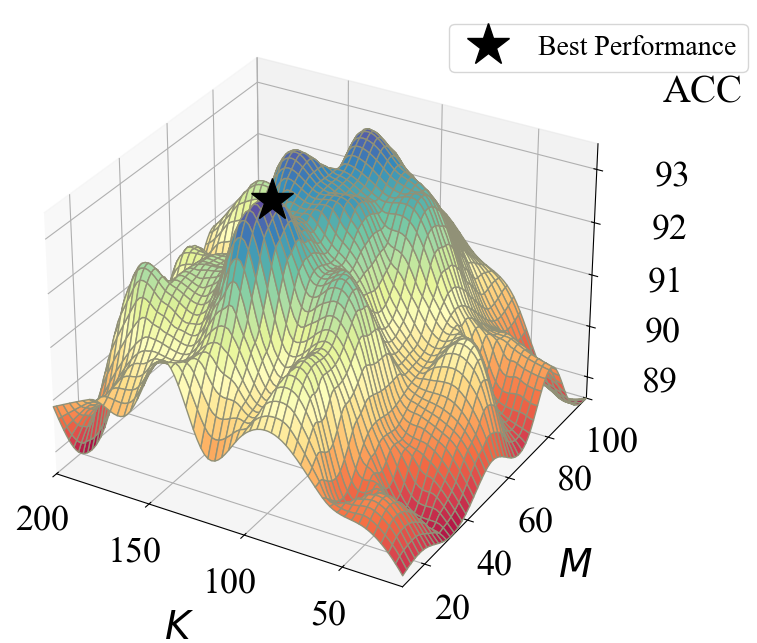

In [1]:
#以下是为了呈现画图效果和适应编造数据的改版
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import os

# 生成K和M的离散取值（K:20~200，步长20；M:10~100，步长10）
np.random.seed(45)  # 固定随机种子
K = np.arange(20, 220, 20)  # [20,40,...,200]
M = np.arange(10, 110, 10)   # [10,20,...,100]
K, M = np.meshgrid(K, M)
K = K.flatten()
M = M.flatten()

# 模拟准确率数据（ACC）：围绕最优值形成平滑分布，加入噪声
# 假设最优参数为K=120，M=60，此时ACC最高（约94%）
base_acc = 88 + 5 * np.exp(-0.00015 * ((K - 120)**2 + (M - 60)** 2))  # 基础曲面
noise = np.random.normal(0, 0.6, size=base_acc.shape)  # 随机噪声
acc = base_acc + noise
acc = np.clip(acc, 85, 95)  # 限制在合理范围

# 转换为代码所需的列表格式：[{K, M, acc}, ...]
data_list = []
for k, m, a in zip(K, M, acc):
    data_list.append({
        'num_of_retrieved_items': int(k),
        'num_of_retrieved_users': int(m),
        'acc': a / 100  # 还原为0~1范围（代码中会×100）
    })

# 设置参数
metric_column = 'acc'
metric_view = 'ACC'
dataset = 'recovery'
save_name = f'{dataset}_{metric_column}_E_U_v3.pdf'
color = 'Spectral'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 32

# 使用编造的数据（替代CSV读取）
js = data_list  # data_list为上文编造的数据

# 提取x(K)、y(M)、z(ACC)
x = np.array([j['num_of_retrieved_items'] for j in js])
y = np.array([j['num_of_retrieved_users'] for j in js])
z = np.array([j[metric_column] * 100 for j in js])  # 转为百分比

# 插值处理（生成平滑网格）
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='cubic')  # 三次插值

# 绘制3D图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 找到性能最优的点
max_index = np.argmax(z)
best_x = x[max_index]
best_y = y[max_index]
best_z = z[max_index]
print(f'Best Performance: K={best_x}, M={best_y}, ACC={best_z:.2f}%')

# 设置坐标轴范围
ax.set_xlim([min(x), max(x)])
ax.set_ylim([min(y), max(y)])
ax.set_zlim([min(z), max(z)])

# 绘制平滑曲面
surf = ax.plot_surface(xi, yi, zi, cmap=color, edgecolor='#919177', zorder=1)

# 设置坐标轴标签和样式
ax.set_xlabel(r'$K$', fontsize=28, labelpad=30)
ax.set_ylabel(r'$M$', fontsize=28, labelpad=30)
ax.set_zlabel('', fontsize=28, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.invert_xaxis()  # X轴反向
ax.zaxis.set_tick_params(pad=25)
ax.yaxis.set_tick_params(pad=10)
ax.xaxis.set_tick_params(pad=8)

# 添加指标标签和最优值标记
ax.text2D(1.06, 0.85, metric_view, fontsize=28, transform=ax.transAxes)
ax.plot([best_x], [best_y], [best_z + 0.005], color='black', marker='*',
        markersize=32, linestyle='None', label='Best Performance', zorder=10)
ax.legend(loc='upper right', bbox_to_anchor=(1.22, 1), fontsize=20)

# 保存并显示
os.makedirs('colors', exist_ok=True)
plt.savefig(save_name, format='pdf')
plt.show()